In [42]:
using JuMP, Ipopt, LinearAlgebra
using ForwardDiff

In [43]:
# Line search
function bisection(f,a,b)
    l = 1e-12
    bᵢ = b
    aᵢ = a
    λ = 0
    while bᵢ - aᵢ > l
        λ = (aᵢ + bᵢ)/2
        ∇f= ForwardDiff.derivative(f,λ)
        if abs(∇f) < l # equivalent to ∇f = 0
            return λ
        elseif ∇f > 0  # left move
            aᵢ₊₁ = aᵢ
            bᵢ₊₁ = λ
        else           # move right
            aᵢ₊₁ = λ
            bᵢ₊₁ = bᵢ
        end
        aᵢ = aᵢ₊₁
        bᵢ = bᵢ₊₁
    end
        return λ
end;

function newton(f, x, N = 1000; ϵ = 1e-10, λ = 1.0, a = 0.0, b = 2.0)
    tini = time()                  # Start timer
    ∇(f, x)  = ForwardDiff.gradient(f, x)
    H(f, x) = ForwardDiff.hessian(f, x)

    for i = 1:N
        ∇fᵢ = ∇(f, x)               # Gradient
        if norm(∇fᵢ) < ϵ            # Stopping condition #1
            tend = time() - tini    # Computation time
            return x, f(x), tend, i # Return cost, time, iterations
        end
        d = -H(f, x)\∇fᵢ            # Newton direction
        ls(λ) = f(x + λ*d)          # Line search via bisection
        λ = bisection(ls,a,b)
        x = x + λ*d                 # Move to a new point
    end
    tend = time() - tini            # Computation time
    return x, f(x), tend, N         # Return x, f(x), time, iterations
end;

In [44]:
# We will consider this problem
f(x) = x[1]^2+ x[2]^2   # min f(x)
h(x) = x[1] + x[2] - 1  # h(x) = 0

h (generic function with 1 method)

In [45]:
# First, we will solve it using JuMP and Ipopt
m = Model()
@variable(m, x[1:2] >= 0)
@objective(m, Min, sum(x[i]^2 for i = 1:2))
@constraint(m, sum(x[i] for i = 1:2) == 1)

set_optimizer(m, Ipopt.Optimizer)
optimize!(m)
println("Optimal solution from Ipopt: ", value.(x))

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [46]:
# Now, let's see if we can obtain the same results with
# an implementation of the augmented Lagrangian method of multipliers

# Initial parameters
μ = 100.0      # penalty term. Try different values
ϵ = 1e-9       # tolerance
xᵏ = [0.0,0.0] # initial point
vᵏ = 0         # initial dual value

# Method of multipliers implementation
function method_of_multipliers(f, h, xᵏ = [0.0,0.0], vᵏ = 0.0, μ = 10.0, ϵ = 1e-9)
    println("\nStarting method of multipliers...")
    println("Starting point: ", xᵏ, "/ Objective: ", f(xᵏ), "/ Dual multiplier: ", vᵏ, "/ Residue: ", abs(h(xᵏ)))
    k = 1
    x_traj = zeros(100, length(xᵏ))
    x_traj[1, :] = xᵏ
    while (abs(h(xᵏ)) > ϵ)
        L(x) = f(x) + vᵏ*(h(x)) + μ*(h(x))^2 # aug. Lag. function
        xᵏ,⋅,⋅,⋅ = newton(L,xᵏ)              # primal step using Newton's
        println("Current point: ", round.(xᵏ, digits=4), "/ Objective: ", round(f(xᵏ), digits=4), "/ Dual multiplier: ", round.(vᵏ, digits=4), "/ Residue: ", round(abs(h(xᵏ)),digits=4))
        vᵏ = vᵏ + 2μ*(h(xᵏ))                 # dual step
        k += 1
        x_traj[k, :] = xᵏ
    end
    println("Converged in ",k-1 , " iterations. Optimal: ", round.(xᵏ, digits=4))
    return xᵏ, x_traj[1:k,:], vᵏ
end

method_of_multipliers (generic function with 5 methods)

In [47]:
using Plots, LaTeXStrings
gr()

Plots.GRBackend()

In [48]:
# Checking if we obtain the same solution with ALMM:
μ = 5.0
x_opt, x_traj, vᵏ = method_of_multipliers(f, h, [5.0, 5.0], 0, μ);


Starting method of multipliers...
Starting point: [5.0, 5.0]/ Objective: 50.0/ Dual multiplier: 0/ Residue: 9.0
Current point: 

[0.4545, 0.4545]/ Objective: 0.4132/ Dual multiplier: 0.0/ Residue: 0.0909
Current point: [0.4959, 0.4959]/ Objective: 0.4918/ Dual multiplier: -0.9091/ Residue: 0.0083
Current point: [0.4996, 0.4996]/ Objective: 0.4992/ Dual multiplier: -0.9917/ Residue: 0.0008
Current point: [0.5, 0.5]/ Objective: 0.4999/ Dual multiplier: -0.9992/ Residue: 0.0001
Current point: [0.5, 0.5]/ Objective: 0.5/ Dual multiplier: -0.9999/ Residue: 0.0
Current point: [0.5, 0.5]/ Objective: 0.5/ Dual multiplier: -1.0/ Residue: 0.0
Current point: [0.5, 0.5]/ Objective: 0.5/ Dual multiplier: -1.0/ Residue: 0.0
Current point: [0.5, 0.5]/ Objective: 0.5/ Dual multiplier: -1.0/ Residue: 0.0
Current point: [0.5, 0.5]/ Objective: 0.5/ Dual multiplier: -1.0/ Residue: 0.0
Converged in 9 iterations. Optimal: [0.5, 0.5]


In [49]:
# Try a different problem executing these:
f(x) = (x[1] .- 2).^2 .+ (x[1] .- 2x[2]).^2    # min f(x)
h(x) = x[1] .- x[2] .+ 1                       # h(x) = 0

μ = 5.0
x_opt, x_traj, vᵏ = method_of_multipliers(f, h, [5.0, 5.0], 0, μ);


Starting method of multipliers...
Starting point: [5.0, 5.0]/ Objective: 34.0/ Dual multiplier: 0/ Residue: 1.0
Current point: 

[0.5714, 1.0]/ Objective: 4.0816/ Dual multiplier: 0.0/ Residue: 0.5714
Current point: [0.1633, 1.0]/ Objective: 6.7472/ Dual multiplier: 5.7143/ Residue: 0.1633
Current point: [0.0466, 1.0]/ Objective: 7.6312/ Dual multiplier: 7.3469/ Residue: 0.0466
Current point: [0.0133, 1.0]/ Objective: 7.8937/ Dual multiplier: 7.8134/ Residue: 0.0133
Current point: [0.0038, 1.0]/ Objective: 7.9696/ Dual multiplier: 7.9467/ Residue: 0.0038
Current point: [0.0011, 1.0]/ Objective: 7.9913/ Dual multiplier: 7.9848/ Residue: 0.0011
Current point: [0.0003, 1.0]/ Objective: 7.9975/ Dual multiplier: 7.9956/ Residue: 0.0003
Current point: [0.0001, 1.0]/ Objective: 7.9993/ Dual multiplier: 7.9988/ Residue: 0.0001
Current point: [0.0, 1.0]/ Objective: 7.9998/ Dual multiplier: 7.9996/ Residue: 0.0
Current point: [0.0, 1.0]/ Objective: 7.9999/ Dual multiplier: 7.9999/ Residue: 0.0
Current point: [0.0, 1.0]/ Objective: 8.0/ Dual multiplier: 8.0/ Residue: 0.0
Current point: [0.0, 1.0]/ Objective: 8.0/ Dual mult

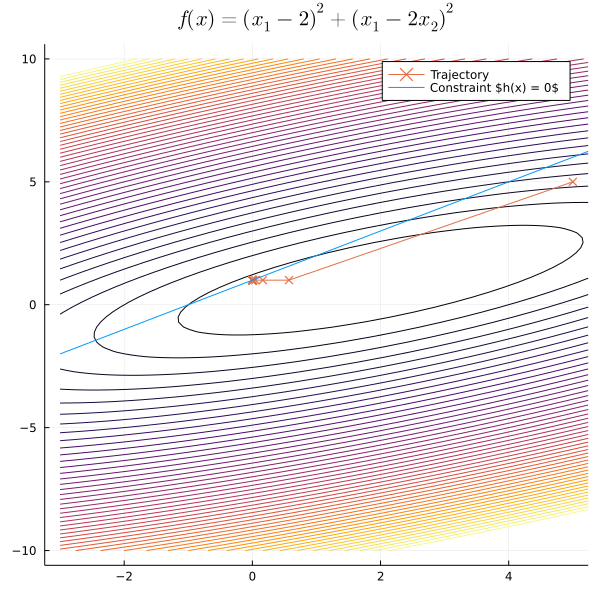

In [50]:
# Plotting the contour of the function 
x = range( -3, 7, length = 100)
y = range( -10, 10, length = 100)

contour(x,y, (x,y) -> f([x,y]), 
    title  = L"f(x) = (x_1-2)^2 + (x_1 - 2x_2)^2 ",
    levels = [0.0 + 10i for i = 1:50],
    cbar = false,
    clims = (0,500),
#     aspect_ratio = :equal
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(x_traj[:,1], x_traj[:,2], label = "Trajectory", marker = :x)

plot!(x, x .+ 1, label = L"Constraint $h(x) = 0$",
    xaxis = ([-3,5]),
    yaxis = ([-10, 10]),
    size = (600, 600),
    color = 1
)

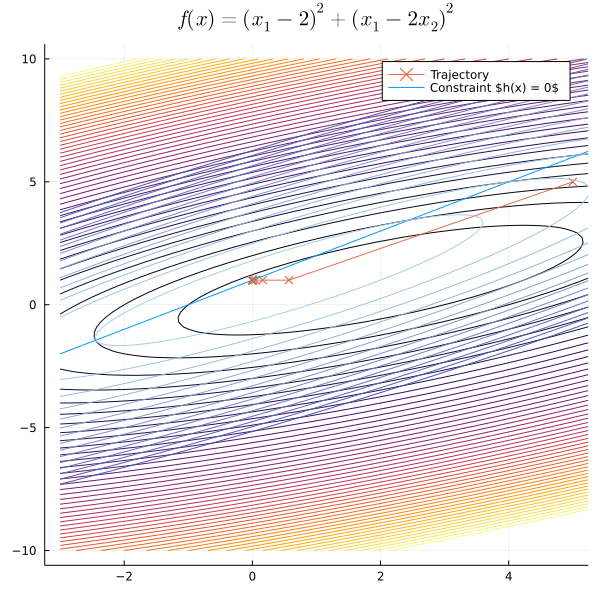

In [51]:
# First iteration with vᵏ = 0
contour!(x,y, (x,y) -> f([x,y]) + μ*(h([x,y]))^2, 
    color = :blues,
    levels = [0.0 + 20i for i = 1:15],
    label = "Augmented lagrangian",
#     aspect_ratio = :equal
)

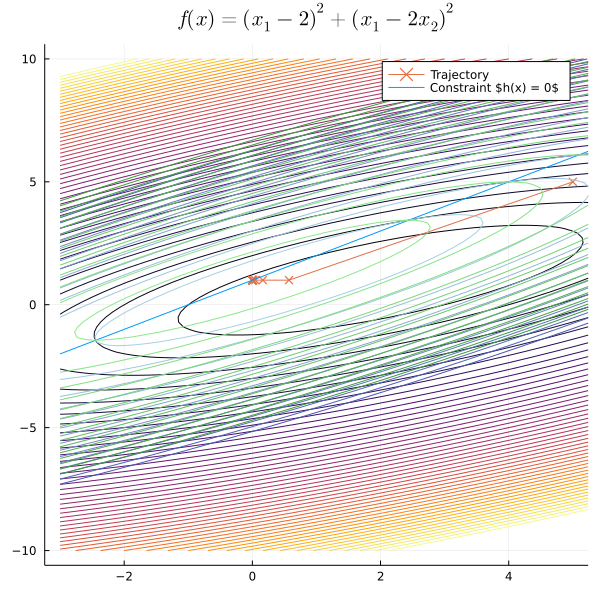

In [52]:
# Augmented lagrangian function at the last iteration
contour!(x,y, (x,y) -> f([x,y]) + vᵏ*(h([x,y])) + μ*(h([x,y]))^2, 
    color = :greens,
    levels = [0.0 + 20i for i = 1:15],
    label = "Augmented lagrangian",
#     aspect_ratio = :equal
)

In [53]:
# Try a different problem executing these (can't use Ipopt because of the first term):
f(x) = (x[1] .- 2).^4 .+ (x[1] .- 2x[2]).^2   # min f(x)
h(x) = x[1]^2 .- x[2]                         # h(x) = 0

x_opt, x_traj, vᵏ = method_of_multipliers(f, h, [4.0, 5.0], 0.0, 1.0);


Starting method of multipliers...
Starting point: [4.0, 5.0]/ Objective: 52.0/ Dual multiplier: 0.0/ Residue: 11.0
Current point: 

[1.1687, 0.7407]/ Objective: 0.5752/ Dual multiplier: 0.0/ Residue: 0.6252
Current point: [1.0687, 0.781]/ Objective: 0.9954/ Dual multiplier: 1.2505/ Residue: 0.3612
Current point: [1.0214, 0.8145]/ Objective: 1.2864/ Dual multiplier: 1.9729/ Residue: 0.2287
Current point: [0.9945, 0.8386]/ Objective: 1.4884/ Dual multiplier: 2.4303/ Residue: 0.1504
Current point: [0.978, 0.8556]/ Objective: 1.6286/ Dual multiplier: 2.7311/ Residue: 0.1009
Current point: [0.9674, 0.8674]/ Objective: 1.7259/ Dual multiplier: 2.9328/ Residue: 0.0684
Current point: [0.9604, 0.8756]/ Objective: 1.7934/ Dual multiplier: 3.0697/ Residue: 0.0468
Current point: [0.9557, 0.8813]/ Objective: 1.8403/ Dual multiplier: 3.1632/ Residue: 0.0321
Current point: [0.9525, 0.8852]/ Objective: 1.8727/ Dual multiplier: 3.2274/ Residue: 0.0221
Current point: [0.9504, 0.888]/ Objective: 1.8953/ Dual multiplier: 3.2716/ Residue: 0.0153
Current point: [0.9489, 0.8899]/ Objective: 1.9109/ Dual multiplier: 3.3022/ Residue: 0.010

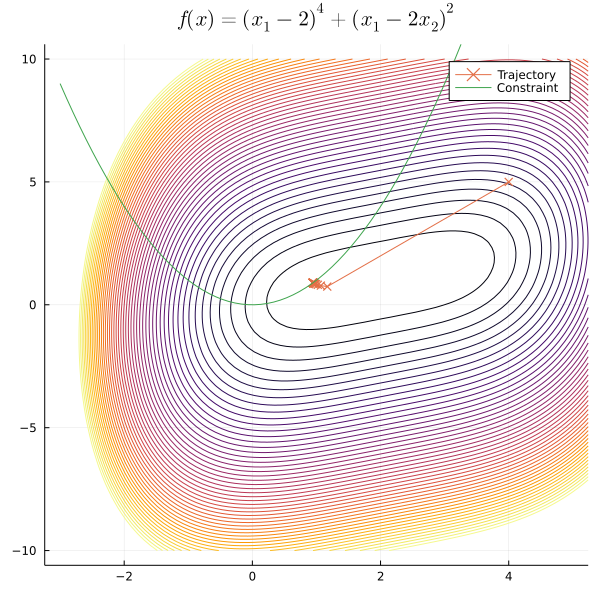

In [54]:
# Plotting the contour of the function 
x = range( -3, 7, length = 100)
y = range( -10, 10, length = 100)

contour(x,y, (x,y) -> f([x,y]), 
    title  = L"f(x) = (x_1-2)^4 + (x_1 - 2x_2)^2 ",
    levels = [0.0 + 10i for i = 1:50],
    cbar = false,
    clims = (0,500),
#     aspect_ratio = :equal
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(x_traj[:,1], x_traj[:,2], label = "Trajectory", marker = :x)

plot!(x, x.^2, label = "Constraint",
    xaxis = ([-3,5]),
    yaxis = ([-10, 10]),
    size = (600, 600)
)

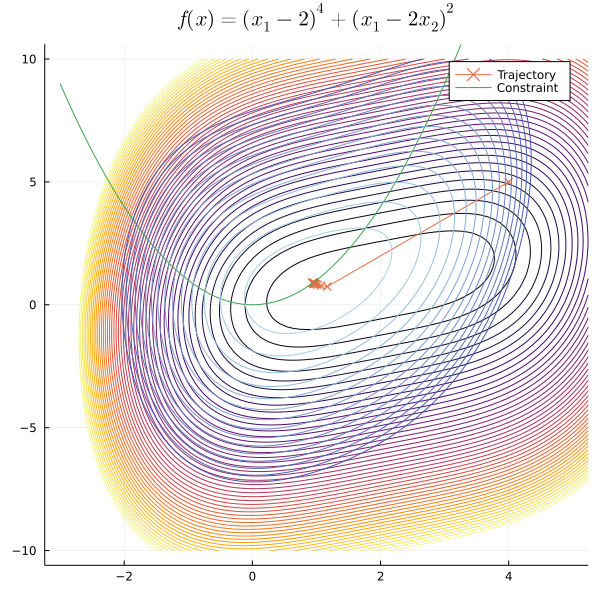

In [55]:
vᵏ = 3.3706855882277065
μ = 1.0

contour!(x,y, (x,y) -> f([x,y]) + vᵏ*(h([x,y])) + μ*(h([x,y]))^2, 
    color = :blues,
    levels = [0.0 + 20i for i = 1:15],
    label = "Augmented lagrangian",
#     aspect_ratio = :equal
)